## Importing necessary libraries


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import re

## Data Preparation - I ensured the data is sorted and the index is consistent

<ipython-input-72-95fd60ff5e00>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


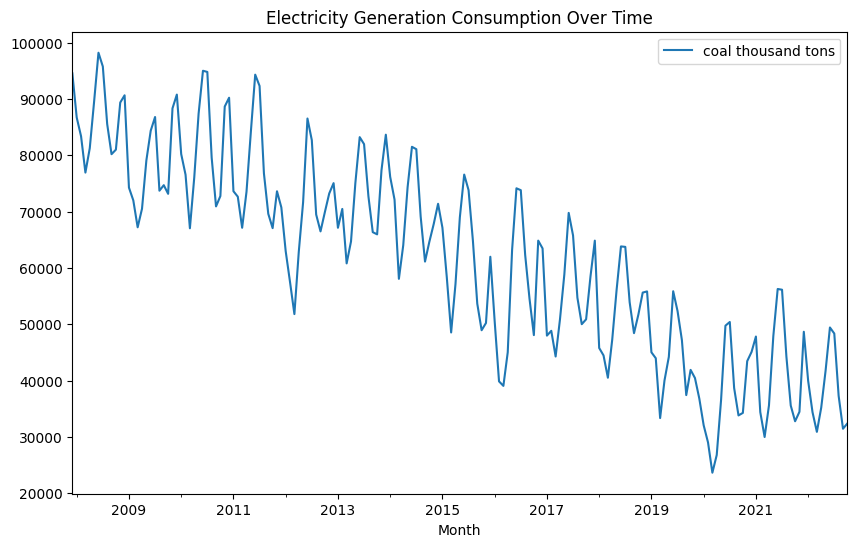

In [72]:
# Load the data and ensure the index is sorted
df = pd.read_csv(
    "Consumption_for_electricity_generation_for_all_sectors_monthly (2).csv",
    parse_dates=['Month'],
    index_col='Month'
).dropna()

df.sort_index(inplace=True, ascending=True)

# Plot the data to visualize trends and seasonality
df.plot(title='Electricity Generation Consumption Over Time', figsize=(10, 6))
plt.show()


## ACF and PACF Analysis - to understand seasonality and determine the need for differencing

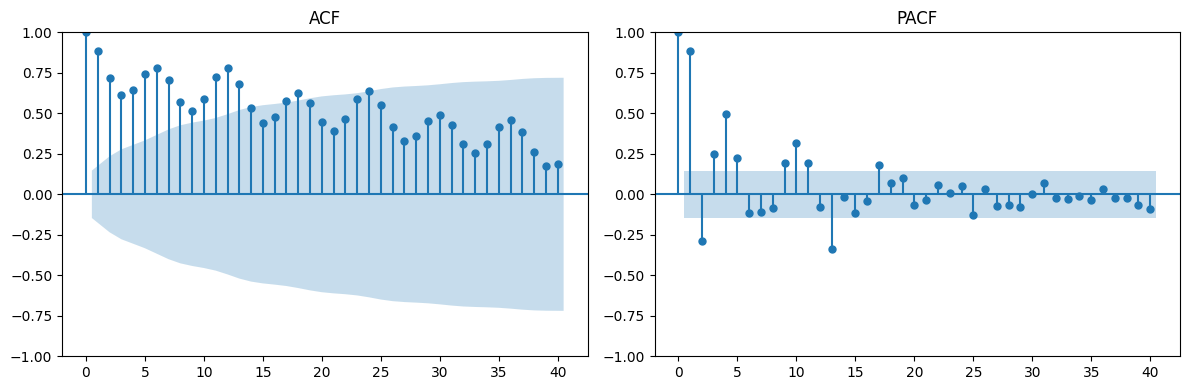

In [73]:
# ACF and PACF plots to identify seasonality and trend
def plot_acf_pacf(y, lags=40):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(y, ax=ax1, lags=lags)
    plot_pacf(y, ax=ax2, lags=lags)
    ax1.set_title('ACF')
    ax2.set_title('PACF')
    plt.tight_layout()
    plt.show()

plot_acf_pacf(df['coal thousand tons'])


### Seasonality
Regular spikes in the ACF at 12-lag intervals indicate strong yearly seasonality. This requires models that can account for this periodic pattern, like Holt-Winters or SARIMA with seasonal components.

A slow decay in the ACF and a significant spike at the first lag in the PACF suggest a trend, indicating that differencing might be needed to achieve stationarity before modeling.

Given the observed seasonality and trend, use SARIMA with seasonal orders and apply differencing if required. Evaluate the models using Mean Absolute Percentage Error (MAPE) to choose the best one for forecasting.

Holt-Winters Model - I constructed a Holt-Winters model with trend and seasonal components, and calculated MAPE

In [74]:
# Construct Holt-Winters model
hw_model = ExponentialSmoothing(
    df['coal thousand tons'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

hw_forecast = hw_model.forecast(12)

# Calculate MAPE for Holt-Winters
hw_mape = mean_absolute_percentage_error(
    df['coal thousand tons'][-12:],
    hw_forecast
)

print("Holt-Winters MAPE:", hw_mape)

Holt-Winters MAPE: 0.09577056666542444


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Auto-ARIMA and SARIMA - next I used Auto-ARIMA to find the best SARIMA model, then fitted it and calculated MAPE



In [75]:
# Auto-ARIMA to determine the best SARIMA model
sarima_model = auto_arima(
    df['coal thousand tons'],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3708.731, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3644.933, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3665.849, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3707.072, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3706.609, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3636.193, Time=0.48 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3623.066, Time=0.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3621.066, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3663.402, Time=0.16 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3623.026, Time=0.82 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3650.592, Time=0.77 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.47 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3582.273, Time=0.89 sec
 ARIMA(0,1,0)(0,0,1)[12] inte

In [76]:
# Fit the SARIMA model and forecast 12 months
sarima = SARIMAX(
    df['coal thousand tons'],
    order=sarima_model.order,
    seasonal_order=sarima_model.seasonal_order
)

results = sarima.fit()
sarima_forecast = results.get_forecast(steps=12)
sarima_mean_forecast = sarima_forecast.predicted_mean
sarima_confidence_intervals = sarima_forecast.conf_int()

# Calculate MAPE for SARIMA
sarima_mape = mean_absolute_percentage_error(
    df['coal thousand tons'][-12:],
    sarima_mean_forecast
)

print("SARIMA MAPE:", sarima_mape)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA MAPE: 0.04458458250319316


## Plotting SARIMA Forecast with confidence intervals

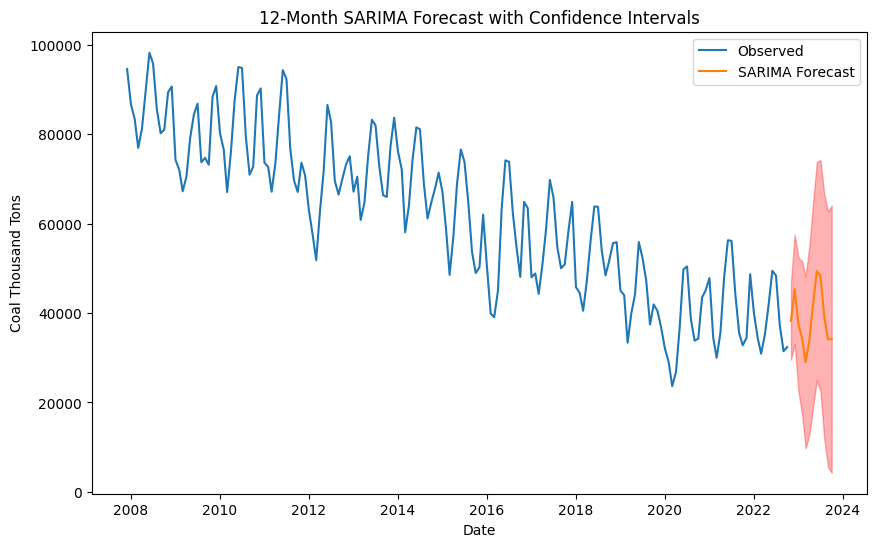

In [78]:
# Plot the SARIMA forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['coal thousand tons'], label='Observed')
plt.plot(sarima_mean_forecast.index, sarima_mean_forecast, label='SARIMA Forecast')
plt.fill_between(
    sarima_mean_forecast.index,
    sarima_confidence_intervals.iloc[:, 0],
    sarima_confidence_intervals.iloc[:, 1],
    color='red',
    alpha=0.3
)
plt.xlabel("Date")
plt.ylabel("Coal Thousand Tons")
plt.legend()
plt.title("12-Month SARIMA Forecast with Confidence Intervals")
plt.show()


## Model Comparison - finally, I compared Holt-Winters and SARIMA based on MAPE:



In [80]:
# Determine the best model based on MAPE
if hw_mape < sarima_mape:
    print("Holt-Winters is the better model.")
else:
    print("SARIMA is the better model.")


SARIMA is the better model.
